In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from ruler_generator import RulerGenerator, merge_images
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import os

np_config.enable_numpy_behavior()

2023-04-23 07:14:51.735190: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-23 07:14:51.736724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 07:14:51.764546: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 07:14:51.765030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 07:14:52.201314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
list_ds = tf.data.Dataset.list_files('data/Sketches/input_data/*')

2023-04-23 07:14:52.929281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-23 07:14:52.929556: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
def get_image(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

In [4]:
def add_lines(image):
    image = (image*255)
    color_shift = np.clip(np.random.uniform(.85, 1.1, 3), 0,1)
    i = image = (image*color_shift).astype('uint8')
    image = Image.fromarray(image.numpy())
#     image = ImageEnhance.Contrast(image).enhance(2)
    i_size = image.size
    
    kwargs = {'shape': i_size,
  'line_width': np.clip(np.random.randint(-2,3),1,4),
  'lines': np.random.randint(15,40),
  'v_offset': np.random.random(),
  'raggedness': -.15 + np.random.random()/2,
  'color': np.random.randint(100, 175),
  'color_variation': np.random.randint(-15, 16),
  'angle': np.random.randint(-7, 8)}
    rg = RulerGenerator(**kwargs)
#     image = Image.blend(image, rg.image, .2)
    merged_image = np.stack([i,np.array(rg.image)], axis=3)
    merged_image = merged_image.min(axis=3)
    
    return merged_image, i

def tf_add_lines(image):
    [j,i] = tf.py_function(add_lines, [image],[tf.uint8, tf.uint8])# [tf.float32, tf.float32])
    j = tf.math.divide(j, 255)
    i = tf.math.divide(i,255)
    
    return j, i

2023-04-23 07:14:53.075704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [669]
	 [[{{node Placeholder/_0}}]]
2023-04-23 07:14:53.075860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [669]
	 [[{{node Placeholder/_0}}]]


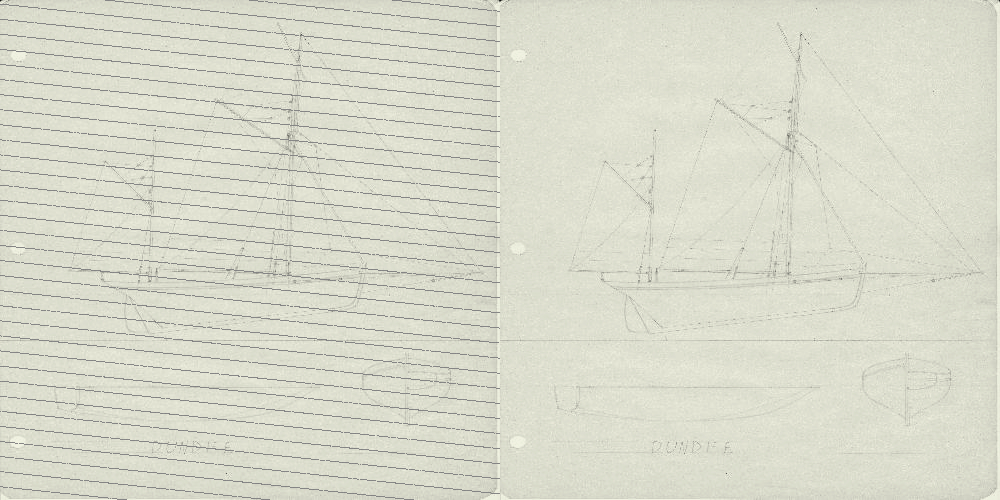

In [5]:
image_ds = list_ds.map(get_image)
image_ds = image_ds.map(tf.image.random_flip_left_right)
image_ds = image_ds.map(tf.image.random_flip_up_down)
train_ds = image_ds.map(tf_add_lines)
train_ds = train_ds.batch(8)
train_ds = train_ds.repeat()

x,y = next(iter(train_ds))
x=(x.numpy()[0]*255).astype('uint8')
y=(y.numpy()[0]*255).astype('uint8')
merge_images(Image.fromarray(x), Image.fromarray(y))



In [6]:
n=48
model = tf.keras.Sequential([
      layers.Input(shape=(500, 500, 3)),
      layers.Conv2D(2*n, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(n, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2DTranspose(n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(2*n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same'),
])

model.compile(optimizer='adam', loss=losses.MeanSquaredError())
# model.fit(train_ds, steps_per_epoch=1, epochs=1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 96)      2688      
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 48)      41520     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 250, 250, 48)     20784     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 500, 500, 96)     41568     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 500, 500, 3)       2595      
                                                                 
Total params: 109,155
Trainable params: 109,155
Non-trai

In [8]:
# model = tf.keras.models.load_model('2023-04-22.mdl/')

In [15]:
history = model.fit(train_ds, steps_per_epoch=16, epochs=200)

Epoch 1/200
16/16 [==============================] - 16s 942ms/step - loss: 0.0017
Epoch 2/200
16/16 [==============================] - 15s 947ms/step - loss: 7.8225e-04
Epoch 3/200
16/16 [==============================] - 15s 939ms/step - loss: 6.2340e-04
Epoch 4/200
16/16 [==============================] - 15s 954ms/step - loss: 5.0992e-04
Epoch 5/200
16/16 [==============================] - 16s 1s/step - loss: 4.4599e-04
Epoch 6/200
16/16 [==============================] - 15s 949ms/step - loss: 5.9366e-04
Epoch 7/200
16/16 [==============================] - 15s 968ms/step - loss: 5.0421e-04
Epoch 8/200
16/16 [==============================] - 16s 1s/step - loss: 4.9877e-04
Epoch 9/200
16/16 [==============================] - 16s 982ms/step - loss: 5.2080e-04
Epoch 10/200
16/16 [==============================] - 15s 967ms/step - loss: 4.7516e-04
Epoch 11/200
16/16 [==============================] - 15s 949ms/step - loss: 4.5393e-04
Epoch 12/200
16/16 [==============================]

16/16 [==============================] - 16s 1s/step - loss: 5.2434e-04
Epoch 97/200
16/16 [==============================] - 16s 1s/step - loss: 4.9701e-04
Epoch 98/200
16/16 [==============================] - 16s 1s/step - loss: 4.0467e-04
Epoch 99/200
16/16 [==============================] - 16s 993ms/step - loss: 4.6664e-04
Epoch 100/200
16/16 [==============================] - 15s 967ms/step - loss: 4.5196e-04
Epoch 101/200
16/16 [==============================] - 16s 993ms/step - loss: 4.9198e-04
Epoch 102/200
16/16 [==============================] - 16s 978ms/step - loss: 4.8135e-04
Epoch 103/200
16/16 [==============================] - 16s 1s/step - loss: 4.4046e-04
Epoch 104/200
16/16 [==============================] - 17s 1s/step - loss: 4.1707e-04
Epoch 105/200
16/16 [==============================] - 17s 1s/step - loss: 4.3100e-04
Epoch 106/200
16/16 [==============================] - 16s 1s/step - loss: 5.3296e-04
Epoch 107/200
16/16 [==============================] - 16s 

16/16 [==============================] - 15s 964ms/step - loss: 4.6900e-04
Epoch 190/200
16/16 [==============================] - 17s 1s/step - loss: 3.7796e-04
Epoch 191/200
16/16 [==============================] - 16s 998ms/step - loss: 4.6293e-04
Epoch 192/200
16/16 [==============================] - 16s 984ms/step - loss: 4.1115e-04
Epoch 193/200
16/16 [==============================] - 16s 1s/step - loss: 3.4464e-04
Epoch 194/200
16/16 [==============================] - 16s 1s/step - loss: 3.9920e-04
Epoch 195/200
16/16 [==============================] - 16s 971ms/step - loss: 4.8793e-04
Epoch 196/200
16/16 [==============================] - 16s 1s/step - loss: 4.6724e-04
Epoch 197/200
16/16 [==============================] - 16s 992ms/step - loss: 3.7656e-04
Epoch 198/200
16/16 [==============================] - 16s 980ms/step - loss: 3.6859e-04
Epoch 199/200
16/16 [==============================] - 16s 999ms/step - loss: 4.2769e-04
Epoch 200/200
16/16 [==========================

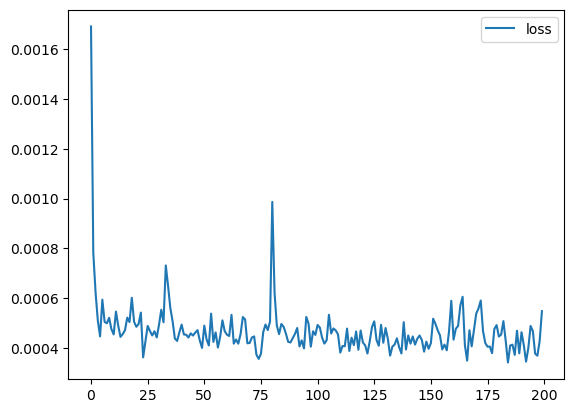

In [16]:
[plt.plot(v, label=k) for k,v in history.history.items()]
plt.legend();

2023-04-23 08:16:25.400696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [669]
	 [[{{node Placeholder/_0}}]]
2023-04-23 08:16:25.400885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [669]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 348ms/step


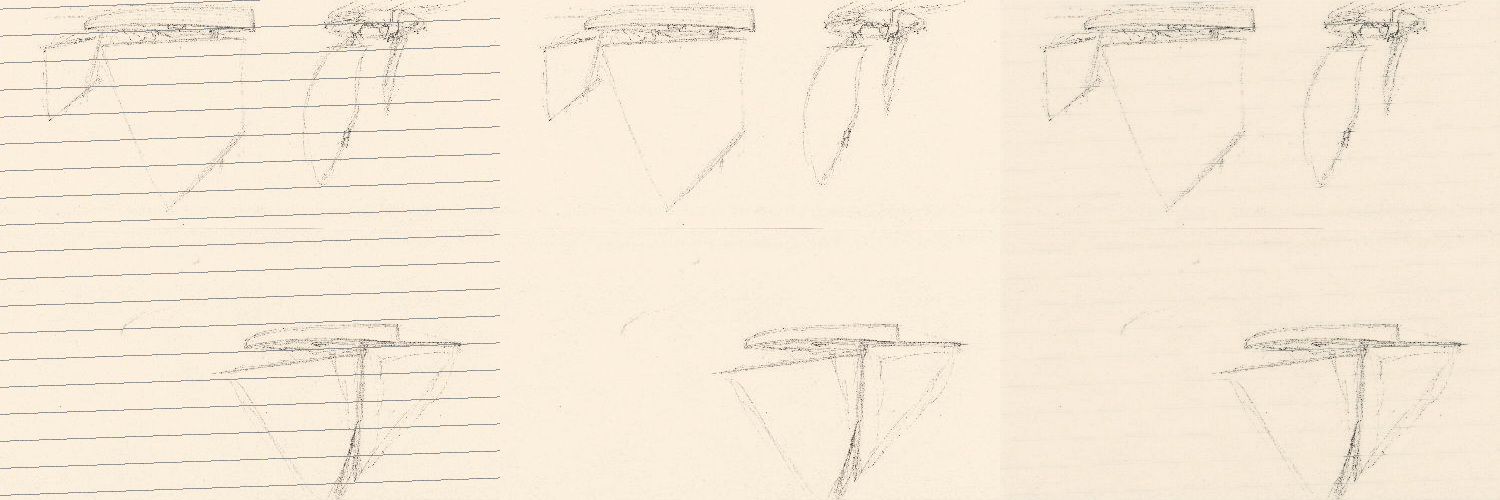

In [17]:
for i in train_ds.take(1).as_numpy_iterator():
    x, y = i

merge_images(    
merge_images(Image.fromarray(((x[0])*255).astype('uint8')),
             Image.fromarray(((y[0]*255).astype('uint8')))),
             
             Image.fromarray((model.predict(x)[0]*255).astype('uint8')))


Sketch_Page_068.jpg
1/1 [==============================] - 0s 56ms/step


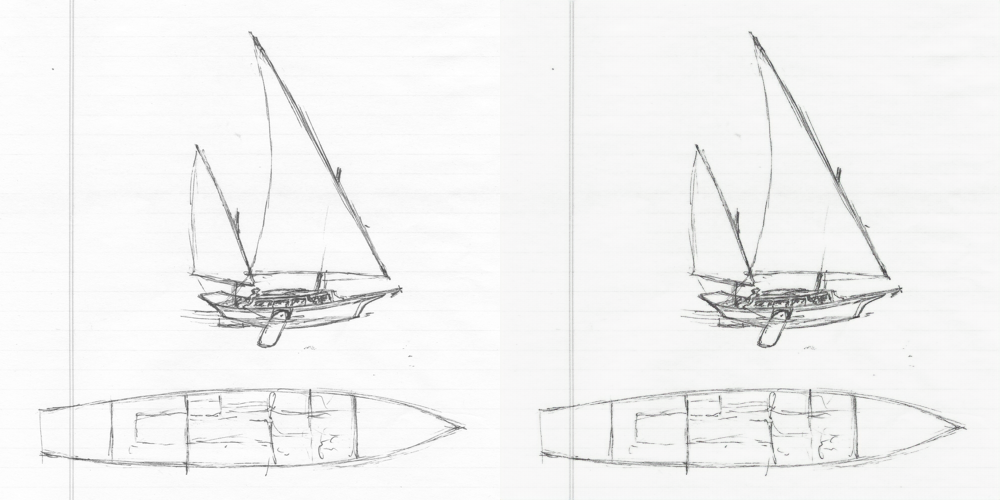

In [18]:
val = np.random.choice([i for i in os.listdir('data/Sketches/Ruled/') if '.jpg' in i])
print(val)
val = Image.open('data/Sketches/Ruled/'+val).convert('RGB').resize((500,500))
val_X = (np.array(val)/255).reshape(-1,500,500,3)
# val_Y = (autoencoder.predict(val_X)[0]*255).astype('uint8')
val_Z = (model.predict(val_X)[0]*255).astype('uint8')
merge_images(val, Image.fromarray(val_Z))#, Image.fromarray(val_Z))

In [19]:
model.save('2023-04-23.mdl')

2023-04-23 08:16:38.100223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,48]
	 [[{{node inputs}}]]
2023-04-23 08:16:38.111830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,48]
	 [[{{node inputs}}]]
2023-04-23 08:16:38.273514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,48]
	 [[{{node inputs}}]]
2023-04

INFO:tensorflow:Assets written to: 2023-04-23.mdl/assets


INFO:tensorflow:Assets written to: 2023-04-23.mdl/assets


In [20]:
from nn_models import get_model

In [23]:
model = get_model((500,500,3), 3)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [ ]:
history = model.fit(train_ds, steps_per_epoch=4, epochs=200)

Epoch 1/200
4/4 [==============================] - 8s 2s/step - loss: 0.0037
Epoch 2/200
4/4 [==============================] - 7s 2s/step - loss: 0.0040
Epoch 3/200
4/4 [==============================] - 8s 2s/step - loss: 0.0054
Epoch 4/200
4/4 [==============================] - 7s 2s/step - loss: 0.0052
Epoch 5/200
4/4 [==============================] - 7s 2s/step - loss: 0.0061
Epoch 6/200
4/4 [==============================] - 7s 2s/step - loss: 0.0049
Epoch 7/200
4/4 [==============================] - 7s 2s/step - loss: 0.0043
Epoch 8/200
4/4 [==============================] - 7s 2s/step - loss: 0.0042
Epoch 9/200
4/4 [==============================] - 7s 2s/step - loss: 0.0042
Epoch 10/200
4/4 [==============================] - 7s 2s/step - loss: 0.0040
Epoch 11/200
3/4 [=====================>........] - ETA: 1s - loss: 0.0045

In [ ]:
[plt.plot(v, label=k) for k,v in history.history.items()]
plt.legend();

In [ ]:
while True:
    try:
        val = np.random.choice([i for i in os.listdir('data/Sketches/Ruled/') if '.jpg' in i])
        print(val)
        val = Image.open('data/Sketches/Ruled/'+val).convert('RGB').resize((500,500))
        val_X = (np.array(val)/255).reshape(-1,500,500,3)
        # val_Y = (autoencoder.predict(val_X)[0]*255).astype('uint8')
        val_Z = (model.predict(val_X)[0]*255).astype('uint8')
        
        break
    except:
        continue
merge_images(val, Image.fromarray(val_Z))#, Image.fromarray(val_Z))

In [ ]:
for i in train_ds.take(1).as_numpy_iterator():
    x, y = i

merge_images(    
merge_images(Image.fromarray(((x[0])*255).astype('uint8')),
             Image.fromarray(((y[0]*255).astype('uint8')))),
             
             Image.fromarray((model.predict(x)[0]*255).astype('uint8')))